In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [2]:
directory = 'img_align_celeba'

dataset = tf.keras.preprocessing.image_dataset_from_directory(directory=directory, color_mode='rgb',
                                                   batch_size=128, image_size=(32,32), label_mode=None,
                                                   shuffle=True, seed=42)


dataset=dataset.map(lambda x: x /255.00)


Found 1008 files.


In [3]:
from mpl_toolkits.axes_grid1 import ImageGrid

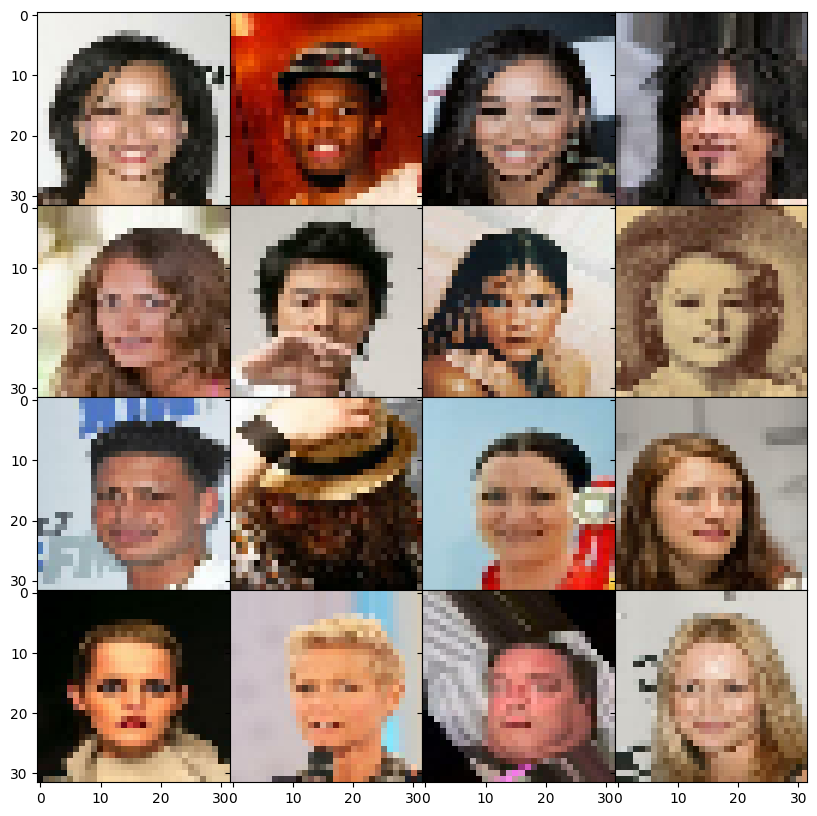

In [4]:
it=iter(dataset)
one_batch = next(it).numpy()
images = one_batch[:16,:,:,:]

# show the image

fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(4,4), 
         axes_pad=0)
for ax,im in zip(grid, images):
    ax.imshow(im)
plt.show()

In [5]:
from tensorflow.keras.layers import Conv2D, LeakyReLU,BatchNormalization, Dropout, Flatten, Dense, Activation, Reshape
from tensorflow.keras import Model, Input

def discriminator_model():
    disc_input = Input(shape=(32,32,3), name='discriminator_network')
    x=Conv2D(filters=64, kernel_size=3, strides=(2,2), padding='same')(disc_input)
    x=LeakyReLU()(x)
    x=Dropout(0.2)(x)
    
    x=Conv2D(filters=128, kernel_size=3, strides=(2,2), padding='same')(x)
    x=LeakyReLU()(x)
    x=Dropout(0.2)(x)
    
    x=Conv2D(filters=128, kernel_size=3, strides=(2,2), padding='same')(x)
    x=LeakyReLU()(x)
    x=Dropout(0.2)(x)
    
    x=Conv2D(filters=64, kernel_size=3, strides=(2,2), padding='same')(x)
    x=LeakyReLU()(x)
    x=Dropout(0.2)(x)
    
    x=Flatten()(x)
    x=Dense(1)(x)
    
    output = Activation('sigmoid')(x)
    
    disc=Model(inputs = disc_input, outputs=output)
    
    return disc

In [6]:
disc_model = discriminator_model()
disc_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ discriminator_network (InputLayer)   │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 16, 16, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 2, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             257 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297,281 (1.13 MB)

 Trainable params: 297,281 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from tensorflow.keras.layers import Conv2D, LeakyReLU, BatchNormalization, Dropout, Flatten, Dense, Activation, Reshape, Conv2DTranspose
from tensorflow.keras import Model, Input

def generator_model(z_dim=100):
    gen_input = Input(shape=(z_dim,), name='generator_network')
    
    x = Dense(8*8*3)(gen_input)
    x = Reshape(target_shape=(8,8,3))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(filters=512, kernel_size=3, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(filters=256, kernel_size=3, strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(filters=128, kernel_size=3, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(filters=128, kernel_size=3, strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
        
    x = Conv2DTranspose(filters=64, kernel_size=3, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(filters=3, kernel_size=3, strides=(1,1), padding='same')(x)
    fake_images_gen = LeakyReLU()(x)
    
    model_gen = Model(inputs=gen_input, outputs=fake_images_gen)
    
    return model_gen

In [9]:
gen_model = generator_model()

In [10]:
gen_model.summary(0)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ generator_network (InputLayer)       │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 192)                 │          19,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 3)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 8, 8, 3)             │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 8, 8, 3)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 512)           │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 16, 16, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_12 (LeakyReLU)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 64)          │             2

 Total params: 1,736,143 (6.62 MB)

 Trainable params: 1,733,961 (6.61 MB)

 Non-trainable params: 2,182 (8.52 KB)

In [7]:
disc_model = discriminator_model()
gen_model = generator_model()
# Image Classification CNN
# Compile the model that trains disc.
disc_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

NameError: name 'generator_model' is not defined

In [ ]:
z_dim = 100
disc_model.trainable = False
model_input = Input(shape=(z_dim,), name='model_input')
model_output = disc_model(gen_model(model_input))

model = Model(model_input, model_output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ model_input (InputLayer)             │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_3 (Functional)            │ (None, 32, 32, 3)           │       1,736,143 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_2 (Functional)            │ (None, 1)                   │         297,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,033,424 (7.76 MB)

 Trainable params: 1,733,961 (6.61 MB)

 Non-trainable params: 299,463 (1.14 MB)

In [24]:
def train_discriminator(batch, batch_size):
    # Convert batch to numpy array (if it's not already)
    batch = batch.numpy()  # Ensure the batch is a Numpy array

    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    # Train the discriminator on real data
    disc_model.train_on_batch(batch, valid)

    # Generate fake images and train discriminator on them
    noise = np.random.normal(0, 1, (batch_size, z_dim))
    gen_image = gen_model(noise)  # Use gen_model directly instead of predict
    disc_model.train_on_batch(gen_image, fake)


In [25]:
disc_model = discriminator_model()
disc_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
def train_generator(batch_size):
    valid = np.ones((batch_size, 1))  # Target for the generator
    noise = np.random.normal(0, 1, (batch_size, z_dim))
    model.train_on_batch(noise, valid)  # Model connects generator and discriminator

In [27]:
def save_image(fake_image, path):
    # Ensure image data is in [0, 1] range
    fake_image = (fake_image * 127.5 + 127.5).clip(0, 255).astype(np.uint8)
    image = tf.keras.preprocessing.image.array_to_img(fake_image)
    image.save(path)
    return image

def generate_and_save_image(path):
    noise = np.random.normal(0, 1, (1, z_dim))
    fake_images = gen_model(noise)  # Generate new images
    image = save_image(fake_images[0].numpy(), path)
    plt.imshow(image)
    plt.show()


Epoch 1
Batch 0 completed.


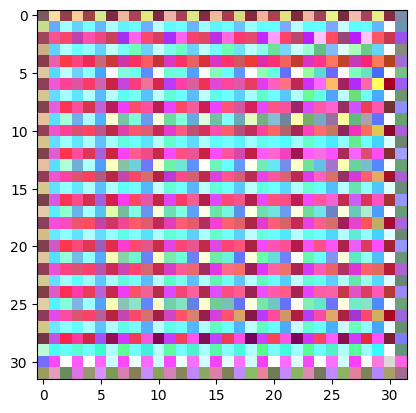

Epoch 2
Batch 0 completed.


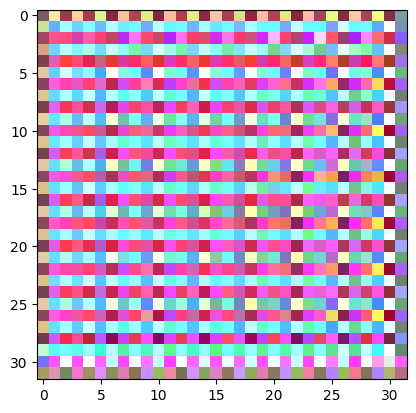

Epoch 3
Batch 0 completed.


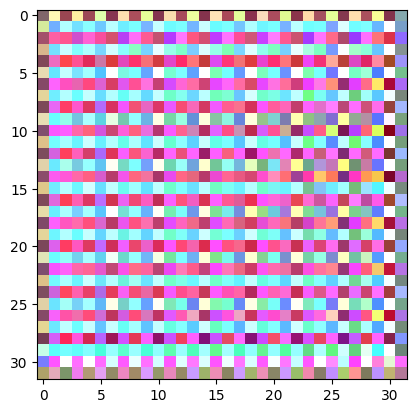

Epoch 4
Batch 0 completed.


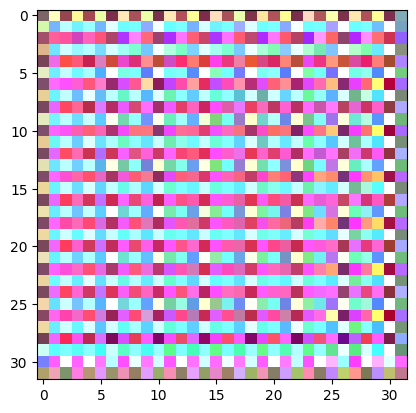

Epoch 5
Batch 0 completed.


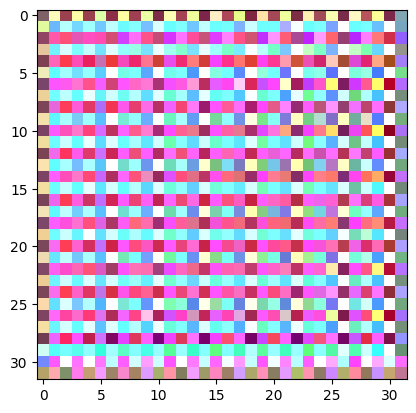

Epoch 6
Batch 0 completed.


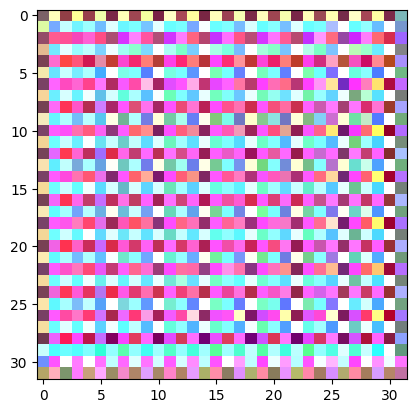

Epoch 7
Batch 0 completed.


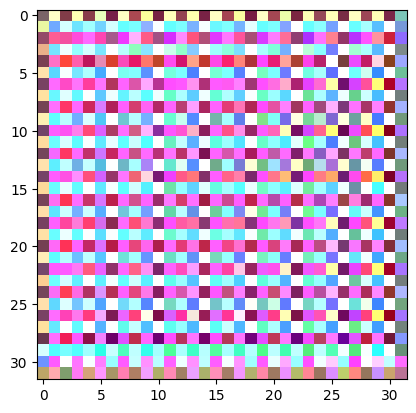

Epoch 8
Batch 0 completed.


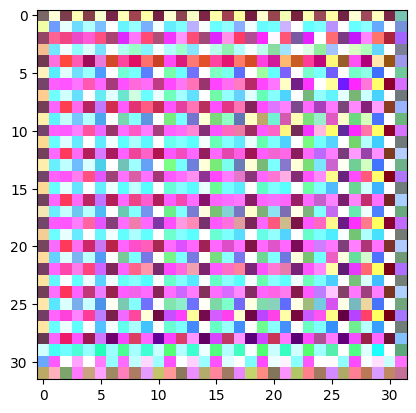

Epoch 9
Batch 0 completed.


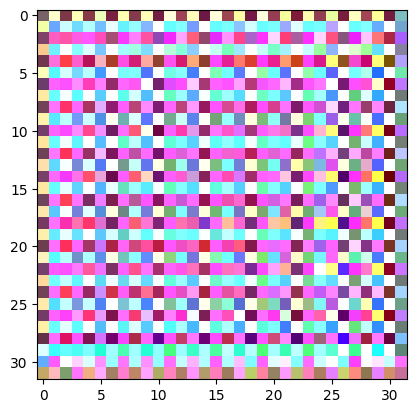

Epoch 10
Batch 0 completed.


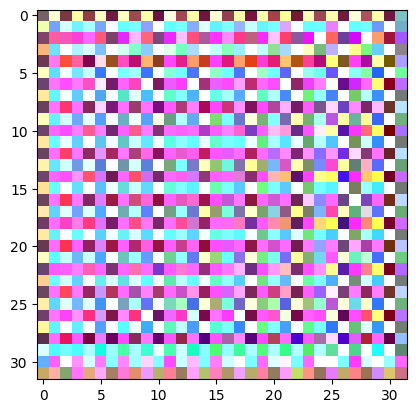

Epoch 11
Batch 0 completed.


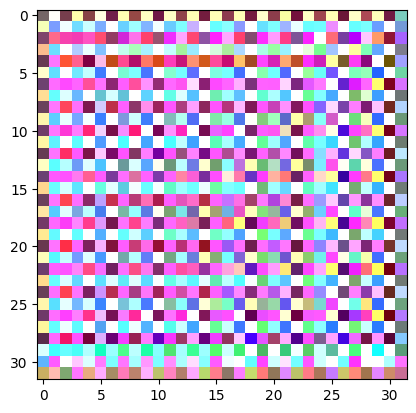

Epoch 12
Batch 0 completed.


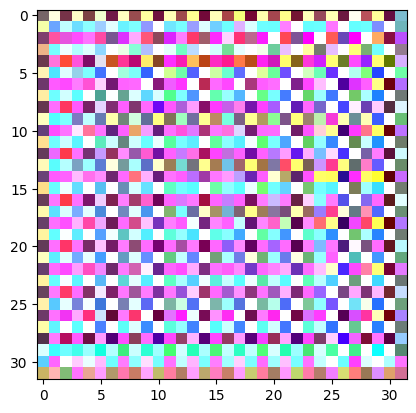

Epoch 13
Batch 0 completed.


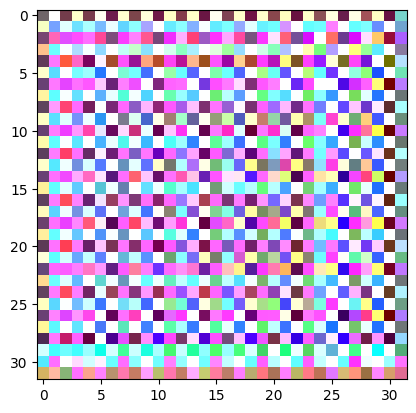

Epoch 14
Batch 0 completed.


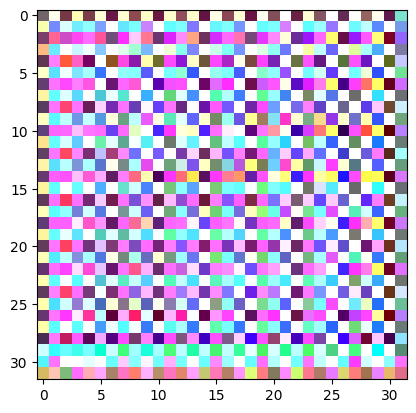

Epoch 15
Batch 0 completed.


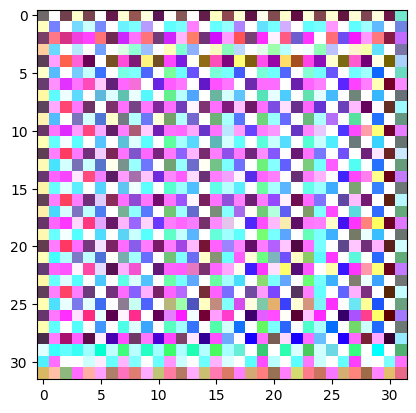

Epoch 16
Batch 0 completed.


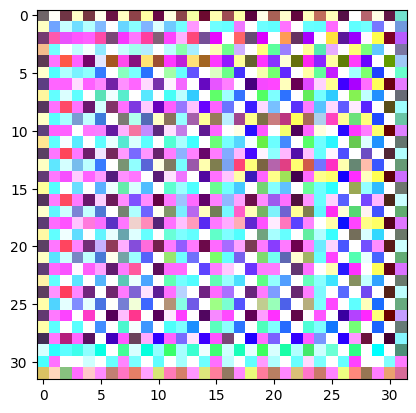

Epoch 17
Batch 0 completed.


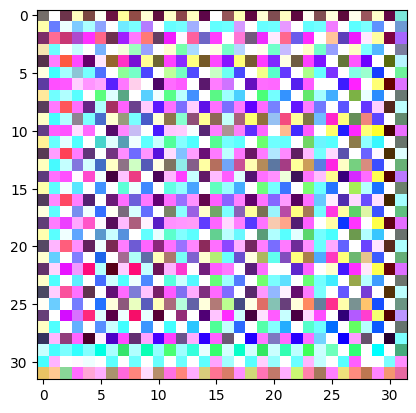

Epoch 18
Batch 0 completed.


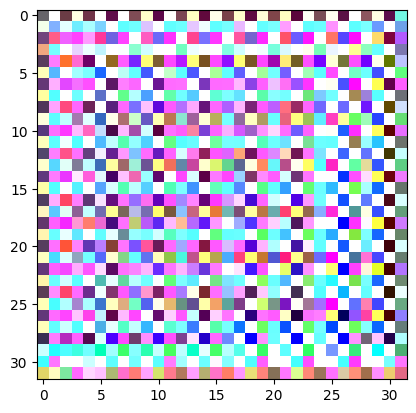

Epoch 19
Batch 0 completed.


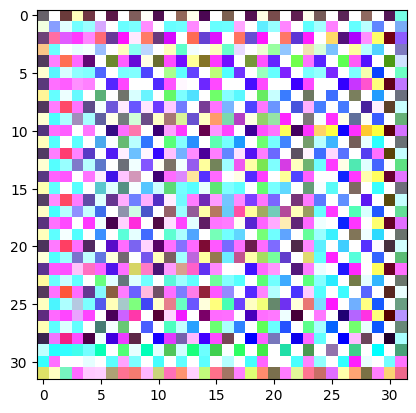

Epoch 20
Batch 0 completed.


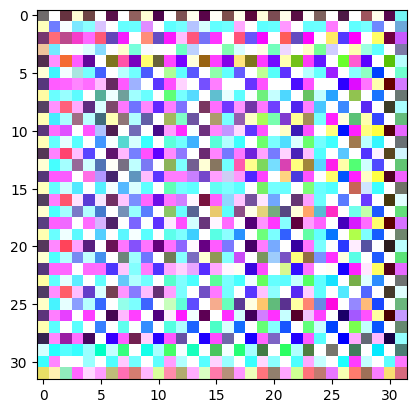

Epoch 21
Batch 0 completed.


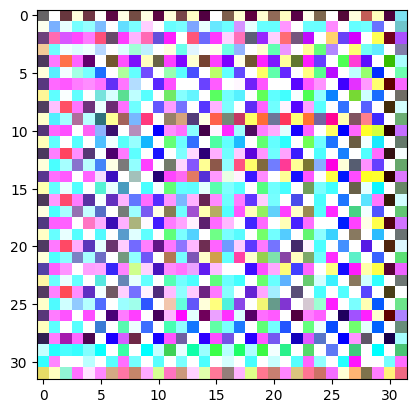

Epoch 22
Batch 0 completed.


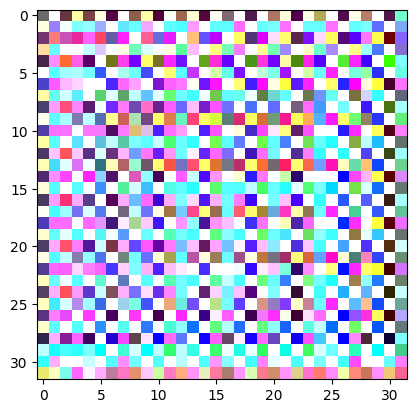

Epoch 23
Batch 0 completed.


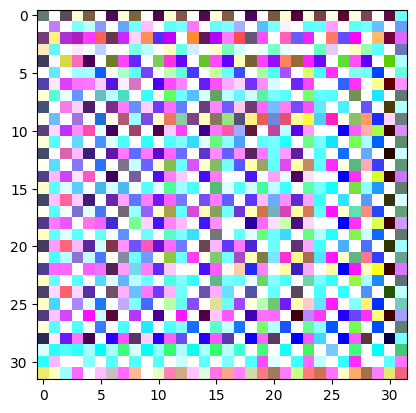

Epoch 24
Batch 0 completed.


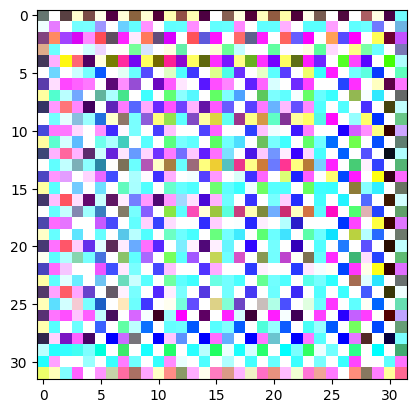

Epoch 25
Batch 0 completed.


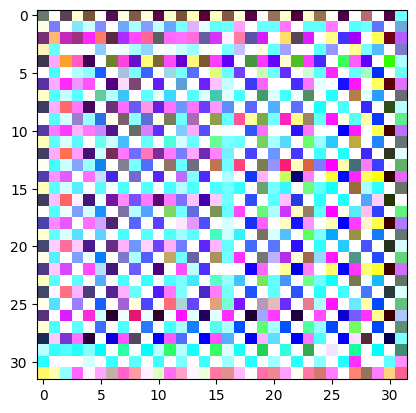

Epoch 26
Batch 0 completed.


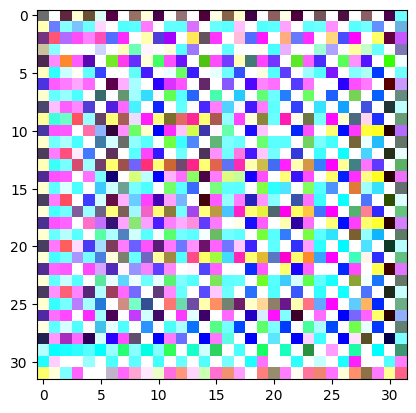

Epoch 27
Batch 0 completed.


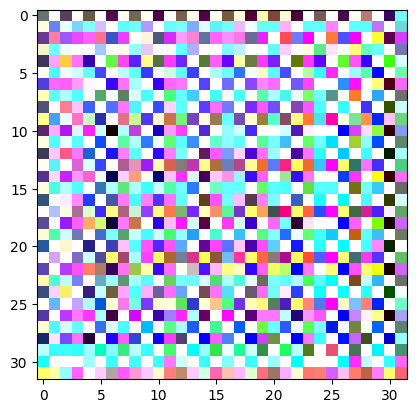

KeyboardInterrupt: 

In [29]:
for epoch in range(1000):
    print(f'Epoch {epoch+1}')
    for i, batch in enumerate(dataset):
        # Ensure batch size is consistent
        train_discriminator(batch, batch.shape[0])
        train_generator(batch.shape[0])
        
        # Save and display every 100 batches
        if i % 100 == 0:
            print(f'Batch {i} completed.')
            PATH = 'generate_face'
            os.makedirs(PATH, exist_ok=True)
            generate_and_save_image(path=f'{PATH}/epoch_{epoch}_batch_{i}.jpg')
